In [ ]:
!pip install shap
!pip install xgboost
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 972.6/972.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 110.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 115.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.7 MB/s eta 0:00:00


In [ ]:

#importing important libraries

# Libraries for data manipulation
import pandas as pd
import numpy as np
import glob

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Library for data preprocessing
from sklearn.preprocessing import OneHotEncoder,StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler

# library to save a model
import joblib

#Library for model building
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Flatten, Dropout, BatchNormalization, MaxPooling1D, Input, Average, concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.optimizers import Adam, RMSprop

#Library for feature selection
import shap

#Library for cross validation
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV

# Libraries for model Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix, classification_report
import time

# Ignoring warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# NOEXPORT

import os
import shutil
from google.colab import drive


BATCH_ID = "IoT Dataset"
TARGET_PATH = "/mnt"


drive.mount('/content/drive', force_remount=True)

if os.path.islink(TARGET_PATH):
    os.unlink(TARGET_PATH)

if os.path.isdir(TARGET_PATH):
    shutil.rmtree(TARGET_PATH)

os.symlink(
    f'/content/drive/My Drive/{BATCH_ID}',
    TARGET_PATH
)

Mounted at /content/drive


In [ ]:
# Specify the path to your CSV files (current directory)
path = '/mnt/*.csv'

# Use glob to get all the csv files in the folder
all_files = glob.glob(path)

# Take only the first 10 files
selected_files = all_files[:10]

# Initialize an empty list to hold DataFrames
dataframes = []

# Loop through the first 10 files and read them into DataFrames
for filename in selected_files:
    df = pd.read_csv(filename)
    dataframes.append(df)

# Concatenate all DataFrames into a single DataFrame
merged_df = pd.concat(dataframes, ignore_index=True)

print("First 10 files merged successfully!")

First 10 files merged successfully!


### FEATURE ENGINEERING FOR THE LABELS

In [ ]:
# Define the categorization rules
def categorize_label(label):
    label = label.strip().upper()

    # DDoS Category
    if label.startswith('DDOS-'):
        subtype = label.split('-')[1].replace('_', ' ').title()
        if 'Ack Fragmentation' in subtype: return ('DDoS', 'ACK fragmentation')
        elif 'Udp Flood' in subtype: return ('DDoS', 'UDP flood')
        elif 'Slowloris' in subtype: return ('DDoS', 'SlowLoris')
        elif 'Icmp Flood' in subtype: return ('DDoS', 'ICMP flood')
        elif 'Rstfinflood' in subtype: return ('DDoS', 'RSTFIN flood')
        elif 'Pshack Flood' in subtype: return ('DDoS', 'PSHACK flood')
        elif 'Http Flood' in subtype: return ('DDoS', 'HTTP flood')
        elif 'Udp Fragmentation' in subtype: return ('DDoS', 'UDP fragmentation')
        elif 'Tcp Flood' in subtype: return ('DDoS', 'TCP flood')
        elif 'Syn Flood' in subtype: return ('DDoS', 'SYN flood')
        elif 'Synonymousip Flood' in subtype: return ('DDoS', 'SynonymousIP flood')
        return ('DDoS', 'Other DDoS')

    # Brute Force
    elif 'DICTIONARYBRUTEFORCE' in label:
        return ('Brute Force', 'Dictionary brute force')

    # Spoofing
    elif 'ARPSPOOFING' in label:
        return ('Spoofing', 'Arp spoofing')
    elif 'DNS_SPOOFING' in label:
        return ('Spoofing', 'DNS spoofing')

    # DoS
    elif label.startswith('DOS-'):
        subtype = label.split('-')[1].replace('_', ' ').title()
        if 'Tcp Flood' in subtype: return ('DoS', 'TCP flood')
        elif 'Http Flood' in subtype: return ('DoS', 'HTTP flood')
        elif 'Syn Flood' in subtype: return ('DoS', 'SYN flood')
        elif 'Udp Flood' in subtype: return ('DoS', 'UDP flood')
        return ('DoS', 'Other DoS')

    # Recon
    elif label.startswith('RECON-') or 'VULNERABILITYSCAN' in label:
        if 'PINGSWEEP' in label: return ('Recon', 'Ping sweep')
        elif 'OSSCAN' in label: return ('Recon', 'OS scan')
        elif 'VULNERABILITYSCAN' in label: return ('Recon', 'Vulnerability scan')
        elif 'PORTSCAN' in label: return ('Recon', 'Port scan')
        elif 'HOSTDISCOVERY' in label: return ('Recon', 'Host discovery')
        return ('Recon', 'Other Recon')

    # Web-based
    elif any(x in label for x in ['SQLINJECTION', 'COMMANDINJECTION', 'BACKDOOR_MALWARE',
                                 'UPLOADING_ATTACK', 'XSS', 'BROWSERHIJACKING']):
        if 'SQLINJECTION' in label: return ('Web-based', 'Sql injection')
        elif 'COMMANDINJECTION' in label: return ('Web-based', 'Command injection')
        elif 'BACKDOOR_MALWARE' in label: return ('Web-based', 'Backdoor malware')
        elif 'UPLOADING_ATTACK' in label: return ('Web-based', 'Uploading attack')
        elif 'XSS' in label: return ('Web-based', 'XSS')
        elif 'BROWSERHIJACKING' in label: return ('Web-based', 'Browser hijacking')

    # Mirai
    elif label.startswith('MIRAI-'):
        subtype = label.split('-')[1]
        if 'GREIP' in subtype: return ('Mirai', 'GREIP flood')
        elif 'GREETH' in subtype: return ('Mirai', 'Greeth flood')
        elif 'UDPPLAIN' in subtype: return ('Mirai', 'UDPPlain')

    # Benign
    elif 'BENIGN' in label:
        return ('Benign', 'Benign')

    return ('Uncategorized', 'Uncategorized')

# Apply categorization to your DataFrame
# Assuming your DataFrame is called df with a 'label' column
merged_df[['Label_class', 'Attack_subtype']] = merged_df['Label'].apply(
    lambda x: pd.Series(categorize_label(x))
)

# Verify categorization
print(merged_df[['Label', 'Label_class', 'Attack_subtype']].value_counts())

Label                    Label_class  Attack_subtype        
DDOS-ICMP_FLOOD          DDoS         ICMP flood                1117567
DDOS-UDP_FLOOD           DDoS         UDP flood                  838444
DDOS-TCP_FLOOD           DDoS         TCP flood                  697227
DDOS-PSHACK_FLOOD        DDoS         PSHACK flood               637002
DDOS-SYN_FLOOD           DDoS         SYN flood                  630924
DDOS-RSTFINFLOOD         DDoS         RSTFIN flood               628773
DDOS-SYNONYMOUSIP_FLOOD  DDoS         SynonymousIP flood         558265
DOS-UDP_FLOOD            DoS          UDP flood                  515275
DOS-TCP_FLOOD            DoS          TCP flood                  415586
DOS-SYN_FLOOD            DoS          SYN flood                  314539
BENIGN                   Benign       Benign                     170515
MIRAI-GREETH_FLOOD       Mirai        Greeth flood               154282
MIRAI-UDPPLAIN           Mirai        UDPPlain                   138777
MIR

In [ ]:
merged_df.sample(5)

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Max,AVG,Std,Tot size,IAT,Number,Variance,Label,Label_class,Attack_subtype
6074583,8.0,17,64.00,15938.227694,0.0,0.00,0.0,0.00,0.00,0.0,...,60,60.00,0.0,60.00,0.000063,100,0.00,DDOS-UDP_FLOOD,DDoS,UDP flood
3670157,20.0,6,65.91,21801.049951,0.0,0.99,0.0,0.01,0.01,0.0,...,123,60.63,6.3,60.63,0.000046,100,39.69,DDOS-SYNONYMOUSIP_FLOOD,DDoS,SynonymousIP flood
2973150,20.0,6,64.00,35412.901047,0.0,1.00,0.0,0.00,0.00,0.0,...,60,60.00,0.0,60.00,0.000028,100,0.00,DDOS-SYNONYMOUSIP_FLOOD,DDoS,SynonymousIP flood
6428211,20.0,6,64.00,14874.473367,1.0,0.00,1.0,0.00,0.00,0.0,...,60,60.00,0.0,60.00,0.000067,100,0.00,DDOS-RSTFINFLOOD,DDoS,RSTFIN flood
2499579,20.0,6,64.00,26336.204948,0.0,0.00,0.0,0.00,0.00,0.0,...,60,60.00,0.0,60.00,0.000038,100,0.00,DOS-TCP_FLOOD,DoS,TCP flood


In [ ]:
merged_df.columns

Index(['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate',
       'fin_flag_number', 'syn_flag_number', 'rst_flag_number',
       'psh_flag_number', 'ack_flag_number', 'ece_flag_number',
       'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count',
       'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP',
       'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max',
       'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Variance', 'Label',
       'Label_class', 'Attack_subtype'],
      dtype='object')

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7300913 entries, 0 to 7300912
Data columns (total 42 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Header_Length    float64
 1   Protocol Type    int64  
 2   Time_To_Live     float64
 3   Rate             float64
 4   fin_flag_number  float64
 5   syn_flag_number  float64
 6   rst_flag_number  float64
 7   psh_flag_number  float64
 8   ack_flag_number  float64
 9   ece_flag_number  float64
 10  cwr_flag_number  float64
 11  ack_count        int64  
 12  syn_count        int64  
 13  fin_count        int64  
 14  rst_count        int64  
 15  HTTP             float64
 16  HTTPS            float64
 17  DNS              float64
 18  Telnet           float64
 19  SMTP             float64
 20  SSH              float64
 21  IRC              float64
 22  TCP              float64
 23  UDP              float64
 24  DHCP             float64
 25  ARP              float64
 26  ICMP             float64
 27  IGMP        

In [ ]:
#  Convert categorical features to appropriate types
categorical_cols = ['Protocol Type', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC',
                    'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC']

merged_df[categorical_cols] = merged_df[categorical_cols].astype('category')

#### Feature Encoding

In [ ]:
# Label Encoding for 'Label_class' (Y)
le = LabelEncoder()
merged_df['Label_class'] = le.fit_transform(merged_df['Label_class'])

#### Feature Scaling

#### DATA CLEANING

In [ ]:
merged_df = merged_df.dropna()

In [ ]:
merged_df.isnull().sum()

,0
Header_Length,0
Protocol Type,0
Time_To_Live,0
Rate,0
fin_flag_number,0
syn_flag_number,0
rst_flag_number,0
psh_flag_number,0
ack_flag_number,0
ece_flag_number,0


In [ ]:
numerical_cols = ['Header_Length', 'Time_To_Live', 'Rate',
                  'fin_flag_number', 'syn_flag_number', 'rst_flag_number',
                  'psh_flag_number', 'ack_flag_number', 'ece_flag_number',
                  'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count',
                  'rst_count', 'Tot sum', 'Min', 'Max', 'AVG', 'Std',
                  'Tot size', 'IAT', 'Number', 'Variance']

Q1 = merged_df[numerical_cols].quantile(0.25)
Q3 = merged_df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Check for outliers
outliers = (merged_df[numerical_cols] < lower_bound) | (merged_df[numerical_cols] > upper_bound)
print(outliers.any())

Header_Length      True
Time_To_Live       True
Rate               True
fin_flag_number    True
syn_flag_number    True
rst_flag_number    True
psh_flag_number    True
ack_flag_number    True
ece_flag_number    True
cwr_flag_number    True
ack_count          True
syn_count          True
fin_count          True
rst_count          True
Tot sum            True
Min                True
Max                True
AVG                True
Std                True
Tot size           True
IAT                True
Number             True
Variance           True
dtype: bool


In [ ]:
# Option 1: Replace outliers with the median
for col in numerical_cols:
    merged_df[col] = np.where(merged_df[col] > upper_bound[col], merged_df[col].median(), merged_df[col])
    merged_df[col] = np.where(merged_df[col] < lower_bound[col], merged_df[col].median(), merged_df[col])

In [ ]:
# Check for non-finite values
print(np.isfinite(merged_df[numerical_cols]).all())

Header_Length      True
Time_To_Live       True
Rate               True
fin_flag_number    True
syn_flag_number    True
rst_flag_number    True
psh_flag_number    True
ack_flag_number    True
ece_flag_number    True
cwr_flag_number    True
ack_count          True
syn_count          True
fin_count          True
rst_count          True
Tot sum            True
Min                True
Max                True
AVG                True
Std                True
Tot size           True
IAT                True
Number             True
Variance           True
dtype: bool


In [ ]:
numerical_cols = ['Header_Length', 'Time_To_Live', 'Rate',
                  'fin_flag_number', 'syn_flag_number', 'rst_flag_number',
                  'psh_flag_number', 'ack_flag_number', 'ece_flag_number',
                  'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count',
                  'rst_count', 'Tot sum', 'Min', 'Max', 'AVG', 'Std',
                  'Tot size', 'IAT', 'Number', 'Variance']

rob_scaler = RobustScaler()
merged_df[numerical_cols] = rob_scaler.fit_transform(merged_df[numerical_cols])

In [ ]:
stand_scaler = StandardScaler()
merged_df[numerical_cols] = stand_scaler.fit_transform(merged_df[numerical_cols])

In [ ]:
# Save both scalers
joblib.dump(rob_scaler, "/mnt/robust_scaler.pkl")
joblib.dump(stand_scaler, "/mnt/standard_scaler.pkl")

['/mnt/standard_scaler.pkl']

In [ ]:
 print(f"RobustScaler fitted on {rob_scaler.n_features_in_} features.")
 print(f"StandardScaler fitted on {stand_scaler.n_features_in_} features.")

RobustScaler fitted on 23 features.
StandardScaler fitted on 23 features.


#### XGB MODEL

In [ ]:
def train_xgb_with_RandomizedSearchCV(X, y, test_size=0.2, random_state=1024, model_filename="/mnt/xgb_model.pkl"):
    """
    Trains an XGBoost classifier using RandomizedSearchCV, computes performance metrics, and saves the model.

    Parameters:
    - X (pd.DataFrame): Feature matrix.
    - y (pd.Series): Target variable.
    - test_size (float): Proportion of data for testing.
    - random_state (int): Random seed for reproducibility.
    - model_filename (str): Name of the file to save the trained model.

    Returns:
    - xgb.XGBClassifier: Best trained model.
    - pd.DataFrame: Metrics (accuracy, precision, recall, f1_score, training_time).
    - pd.DataFrame: Classification report.
    - pd.DataFrame: X_test.
    - pd.Series: y_test.
    - np.array: y_pred.
    """
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

    # Define hyperparameter grid
    param_grid = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'n_estimators': [100, 200]
    }

    # Initialize base XGBoost model
    base_model = xgb.XGBClassifier(enable_categorical=True, random_state=random_state)

    # RandomizedSearchCV setup
    grid_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_grid,
        scoring='accuracy',
        cv=3,
        n_jobs=-1,
    )

    # Training with timing
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Get best model
    best_model = grid_search.best_estimator_

    # Save the trained model
    joblib.dump(best_model, model_filename)
    print(f"Model saved successfully as {model_filename}")

    # Predictions
    y_pred = best_model.predict(X_test)

    # Compute metrics
    metrics_df = pd.DataFrame({
        "Accuracy": [accuracy_score(y_test, y_pred)],
        "Precision": [precision_score(y_test, y_pred, average='weighted')],
        "Recall": [recall_score(y_test, y_pred, average='weighted')],
        "F1-score": [f1_score(y_test, y_pred, average='weighted')],
        "Training_time": [training_time]
    })

    # Generate classification report
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).T

    # Drop support column for visualization
    if 'support' in report_df.columns:
        report_df = report_df.drop(columns=['support'])

    # Plot classification report heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(report_df, annot=True, cmap="Blues", fmt='.2f', linewidths=0.5)
    plt.title("Classification Report Heatmap")
    plt.xlabel("Metrics")
    plt.ylabel("Classes")
    plt.show()

    return best_model, metrics_df, report_df, X_test, y_test, y_pred

In [ ]:
X = merged_df.drop(['Label', 'Label_class', 'Attack_subtype'], axis=1)
y = merged_df['Label_class']

Model saved successfully as /mnt/xgb_model.pkl


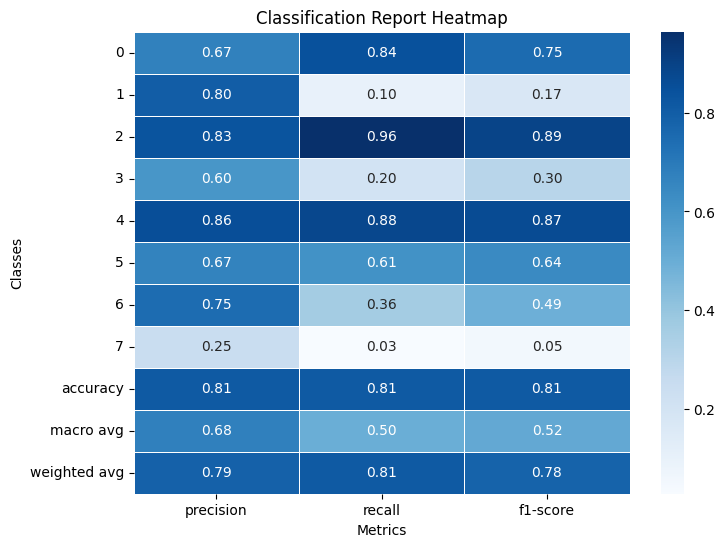

,Accuracy,Precision,Recall,F1-score,Training_time
0,0.813927,0.787117,0.813927,0.779458,485.908224


In [ ]:
# Run the training function
best_model_xgb, metric_df_xgb, report_df_xgb, X_test_xgb, y_test_xgb, y_pred_xgb = train_xgb_with_RandomizedSearchCV(X, y)

metric_df_xgb

# SHAP VISULIZATION

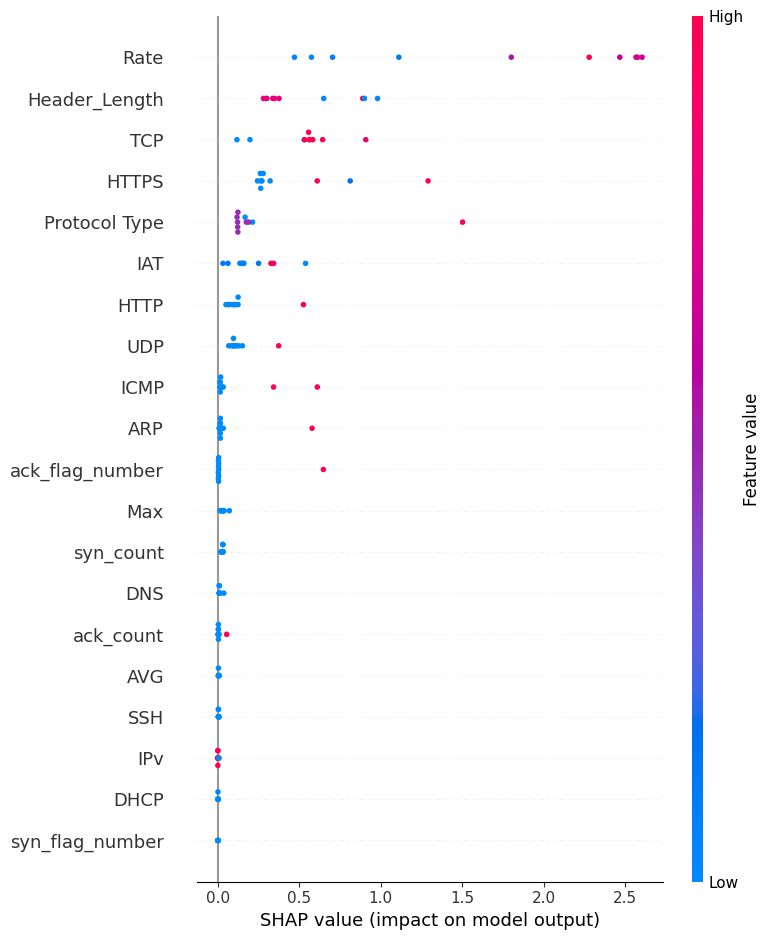

Valid SHAP Features from XGBoost: ['Header_Length', 'Protocol Type', 'Rate', 'syn_flag_number', 'ack_flag_number', 'ack_count', 'syn_count', 'HTTP', 'HTTPS', 'DNS', 'SSH', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'Tot sum', 'Max', 'AVG', 'Std', 'IAT', 'Variance']


In [ ]:
def get_valid_shap_features_xgb(model, X_test, threshold=0.0001):
    """
    Extracts valid SHAP features from an XGBoost model by removing those with SHAP values close to zero.

    Parameters:
    - model: Trained XGBoost model.
    - X_test (pd.DataFrame): Test dataset for SHAP analysis.
    - threshold (float): Minimum SHAP value to consider a feature as valid.

    Returns:
    - List of valid feature names.
    """
    # Convert categorical features to numerical
    X_test_encoded = X_test.copy()
    for col in X_test_encoded.select_dtypes(include=['category', 'object']).columns:
        X_test_encoded[col] = X_test_encoded[col].astype('category').cat.codes

    # Create SHAP explainer
    explainer = shap.TreeExplainer(model)

    # Compute SHAP values
    shap_values = explainer.shap_values(X_test_encoded[:10])

    # Multi-class case: Convert (10, 39, 8) -> (10, 39) by averaging across classes
    if isinstance(shap_values, list) or shap_values.ndim == 3:
        shap_values = np.mean(np.abs(shap_values), axis=-1)  # Aggregate across classes

    # Ensure SHAP values are 2D
    if shap_values.ndim != 2:
        raise ValueError(f"Expected SHAP values to be 2D but got shape {shap_values.shape}")

    # Construct feature importance DataFrame
    feature_importance = pd.DataFrame({
        "Feature": X_test_encoded.columns,
        "SHAP_Value": np.mean(np.abs(shap_values), axis=0)  # Mean absolute SHAP values
    })

    # Filter valid features
    valid_features = feature_importance[feature_importance["SHAP_Value"] > threshold]["Feature"].tolist()

    # SHAP Summary Plot
    shap.summary_plot(shap_values, X_test_encoded[:10], feature_names=X_test_encoded.columns)

    return valid_features

# Call function and store valid features
valid_xgb_features = get_valid_shap_features_xgb(best_model_xgb, X_test_xgb)

print("Valid SHAP Features from XGBoost:", valid_xgb_features)

#### CNN IMPLEMENTATION

In [ ]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [ ]:
def train_cnn(X_train, y_train, X_test, y_test, epochs=2 , batch_size=64):
    """
    Trains a CNN model for multi-class classification.

    Parameters:
    - X_train, y_train: Training data and labels (one-hot encoded)
    - X_test, y_test: Test data and labels (one-hot encoded)
    - epochs: Number of epochs (default=10)
    - batch_size: Batch size for training (default=32)

    Returns:
    - model: Trained CNN model
    - y_pred: Predicted class labels
    - training_time: Training time in seconds
    """

    # Define CNN model
    model = Sequential([
        Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),  # Reduce dropout rate slightly
        BatchNormalization(),

        Conv1D(filters=128, kernel_size=3, activation='relu'),  # Reduce filter size
        Dropout(0.3),
        BatchNormalization(),

        Flatten(),
        Dense(32, activation='relu'),  # Reduce neurons
        Dense(len(np.unique(y)), activation='softmax')
    ])


    model.compile(optimizer=Adam(learning_rate=0.01), loss= 'categorical_crossentropy', metrics=['accuracy'], jit_compile=True)

    # implementing early stopping to halt training when the validation loss stops improving, preventing overfitting
    early_stopping_cnn = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

    # implementing check point to save the best model
    checkpoint_cnn = ModelCheckpoint("best_cnn_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)



    # Convert datasets to NumPy arrays before batching
    X_train_cnn = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_cnn = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

    # One-hot encoding the labels
    y_train_hot = to_categorical(y_train, num_classes=8)
    y_test_hot = to_categorical(y_test, num_classes=8)

    # batching the train_dataset and test_dataset before passing to model.fit
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_cnn, y_train_hot)).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test_cnn, y_test_hot)).batch(batch_size)

    train_dataset = train_dataset.cache()  # Cache the train dataset to make the cardinality known.
    test_dataset = test_dataset.cache()

    # Train model with computational time tracking
    start_time = time.time()
    model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[early_stopping_cnn, checkpoint_cnn], verbose=1)
    end_time = time.time()

    training_time = end_time - start_time

    # Predictions (Get class with highest probability)
    y_pred = model.predict(X_test_cnn)
    y_pred_classes = y_pred.argmax(axis=1)  # Convert probabilities to class labels

    return model, y_pred_classes, training_time

# Train CNN & get predictions
cnn_model, y_pred_cnn, cnn_training_time = train_cnn(X_train, y_train, X_test, y_test)

cnn_model.save("/mnt/cnn_model.h5")

print(f"Training Time: {cnn_training_time:.4f} seconds")

Epoch 1/2
8904/8904 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7784 - loss: 0.5437
Epoch 1: val_accuracy improved from -inf to 0.78686, saving model to best_cnn_model.h5


8904/8904 ━━━━━━━━━━━━━━━━━━━━ 250s 28ms/step - accuracy: 0.7784 - loss: 0.5437 - val_accuracy: 0.7869 - val_loss: 0.5196
Epoch 2/2
8903/8904 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7875 - loss: 0.4955
Epoch 2: val_accuracy improved from 0.78686 to 0.78989, saving model to best_cnn_model.h5


8904/8904 ━━━━━━━━━━━━━━━━━━━━ 234s 26ms/step - accuracy: 0.7875 - loss: 0.4955 - val_accuracy: 0.7899 - val_loss: 0.4784
Restoring model weights from the end of the best epoch: 2.
4452/4452 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step


Training Time: 483.3288 seconds


In [ ]:
def evaluate_cnn(y_test, y_pred, training_time):
    """
    Evaluates the CNN model and saves results in a DataFrame.

    Parameters:
    - y_test: True labels (integer format)
    - y_pred: Predicted labels (integer format)
    - training_time: Training time in seconds

    Returns:
    - DataFrame containing evaluation metrics
    """
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'Training Time'],
        'Value': [accuracy, precision, recall, f1, training_time]
    })

    print("\n=== CNN Evaluation ===\n")
    print(metrics_df)

    return metrics_df

cnn_metrics= evaluate_cnn(y_test, y_pred_cnn, cnn_training_time)
cnn_metrics


=== CNN Evaluation ===

          Metric       Value
0       Accuracy    0.789892
1      Precision    0.659397
2         Recall    0.789892
3       F1-score    0.708950
4  Training Time  483.328848


,Metric,Value
0,Accuracy,0.789892
1,Precision,0.659397
2,Recall,0.789892
3,F1-score,0.708950
4,Training Time,483.328848


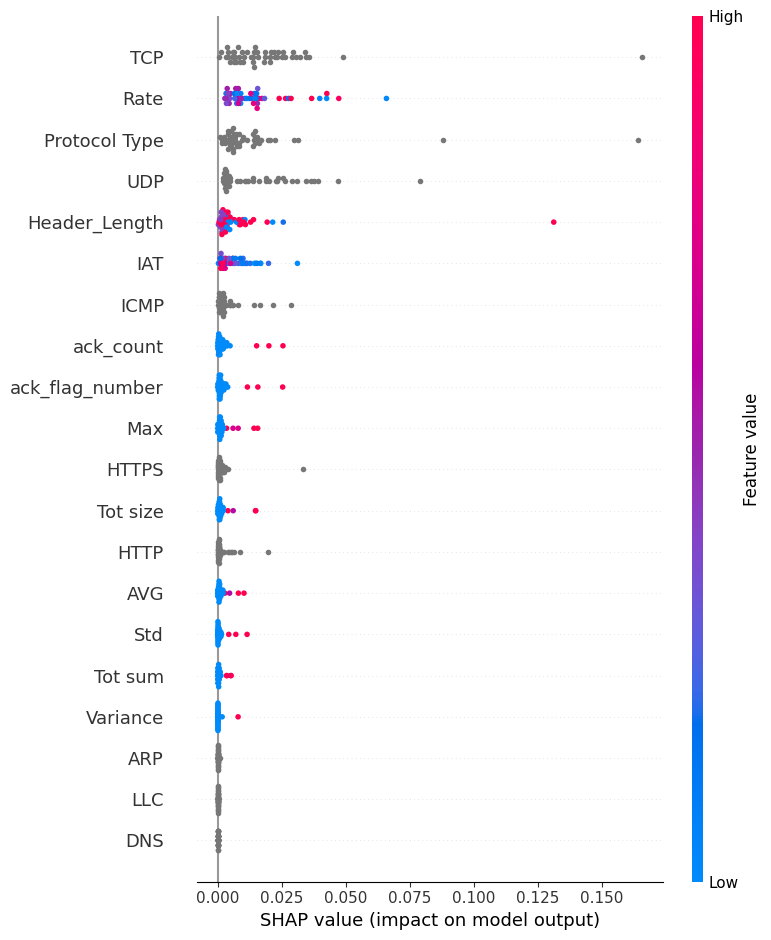

Valid SHAP Features from CNN: ['Header_Length', 'Protocol Type', 'Rate', 'ack_flag_number', 'ack_count', 'HTTP', 'HTTPS', 'TCP', 'UDP', 'ICMP', 'Tot sum', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Variance']


In [ ]:
def get_valid_shap_features_cnn(model, X_test, threshold=0.0001):
    """
    Extracts valid SHAP features from a CNN model by removing those with SHAP values close to zero.

    Parameters:
    - model: Trained CNN model.
    - X_test (pd.DataFrame): Test dataset for SHAP analysis.
    - threshold (float): Minimum SHAP value to consider a feature as valid.

    Returns:
    - List of valid feature names.
    """
    # Ensure eager execution for TensorFlow 2.x
    tf.config.run_functions_eagerly(True)

    # Reshape input for CNN (samples, num_features, 1)
    X_test_cnn = X_test.values.reshape(-1, X_test.shape[1], 1)

    # Use a subset of data for SHAP
    X_test_sample = X_test.iloc[:50]
    X_test_cnn_sample = X_test_cnn[:50]

    # Create SHAP explainer
    explainer = shap.GradientExplainer(model, X_test_cnn_sample)

    # Compute SHAP values
    shap_values = explainer.shap_values(X_test_cnn_sample)

    # If multi-class, convert to NumPy and handle shape
    if isinstance(shap_values, list):
        shap_values = np.array(shap_values)  # Convert to NumPy array

    # Remove singleton dimension: (50, 39, 1, 8) → (50, 39, 8)
    shap_values = np.squeeze(shap_values, axis=2)

    # If still 3D (multi-class case), average across classes (axis=-1)
    if shap_values.ndim == 3:
        shap_values = np.mean(np.abs(shap_values), axis=-1)  # (samples, features)

    if shap_values.ndim != 2:
        raise ValueError(f"Expected SHAP values to be 2D but got shape {shap_values.shape}")

    # Compute mean absolute SHAP values per feature
    mean_shap_values = np.mean(np.abs(shap_values), axis=0)  # (features,)

    if mean_shap_values.ndim != 1:
        raise ValueError(f"Expected mean SHAP values to be 1D but got shape {mean_shap_values.shape}")

    # Construct DataFrame properly
    feature_importance = pd.DataFrame({
        "Feature": X_test.columns,
        "SHAP_Value": mean_shap_values
    })

    # Filter out features with SHAP values below the threshold
    valid_features = feature_importance[feature_importance["SHAP_Value"] > threshold]["Feature"].tolist()

    # Ensure feature and SHAP matrices have the same number of rows for plotting
    if X_test_sample.shape[0] != shap_values.shape[0]:
        raise ValueError(f"Feature and SHAP matrices must have the same number of rows! X_test: {X_test_sample.shape[0]}, SHAP: {shap_values.shape[0]}")

    # SHAP Summary Plot
    shap.summary_plot(shap_values, X_test_sample, feature_names=X_test.columns)

    return valid_features, shap_values  # Return valid feature names

# Call function and store valid features
valid_cnn_features, shap_values_cnn = get_valid_shap_features_cnn(cnn_model, X_test)

print("Valid SHAP Features from CNN:", valid_cnn_features)


=== Feature Importance from SHAP Analysis (CNN) ===
psh_flag_number: 0.0193
Time_To_Live: 0.0153
Protocol Type: 0.0142
ack_flag_number: 0.0139
Header_Length: 0.0082
HTTP: 0.0069
ece_flag_number: 0.0034
fin_flag_number: 0.0024
Rate: 0.0022
ack_count: 0.0018
rst_flag_number: 0.0017
rst_count: 0.0016
syn_flag_number: 0.0015
syn_count: 0.0012
fin_count: 0.0009
cwr_flag_number: 0.0007
HTTPS: 0.0003


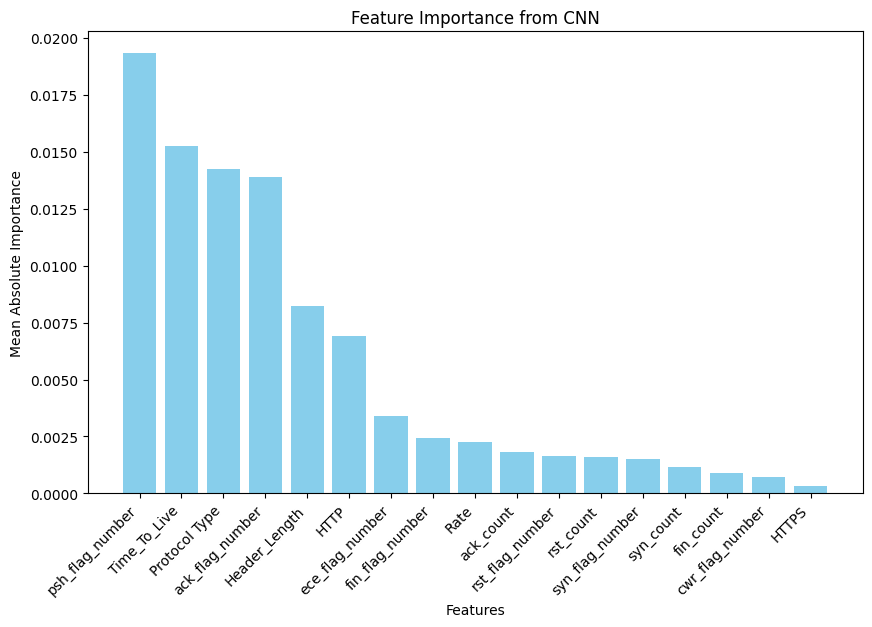

In [ ]:
# Convert feature names to indices
feature_indices = [X_test.columns.get_loc(feature) for feature in valid_cnn_features]

# Compute mean absolute SHAP values for selected features
feature_importance_cnn = np.mean(np.abs(shap_values_cnn[:, feature_indices]), axis=0)

# Flatten if necessary
feature_importance_cnn = feature_importance_cnn.flatten()

# Sort feature importance in descending order
sorted_indices = np.argsort(feature_importance_cnn)[::-1]
sorted_feature_names = np.array(X_test.columns)[sorted_indices]  # Convert to NumPy array

# Print Feature Importance
print("\n=== Feature Importance from SHAP Analysis (CNN) ===")
for name, importance in zip(sorted_feature_names, feature_importance_cnn[sorted_indices]):
    print(f"{name}: {importance:.4f}")

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, feature_importance_cnn[sorted_indices], color='skyblue')
plt.xlabel('Features')
plt.ylabel('Mean Absolute Importance')
plt.title('Feature Importance from CNN')
plt.xticks(rotation=45, ha='right')  # Rotate feature names for better visibility
plt.show()

#### LSTM IMPLEMENTATION

In [ ]:
def train_lstm(X_train, y_train, X_test, y_test, epochs=2, batch_size=64):
    """
    Trains an optimized LSTM model for multi-class classification with reduced runtime.
    """

    # Reshape data for LSTM input
    X_train_lstm = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_lstm = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

    # One-hot encoding labels
    y_train_hot = to_categorical(y_train, num_classes=8)
    y_test_hot = to_categorical(y_test, num_classes=8)

    # Define LSTM Model
    model = Sequential([
        LSTM(16, return_sequences=False, input_shape=(X_train.shape[1], 1), activation='tanh', recurrent_activation='sigmoid'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dense(8, activation='softmax')
    ])

    # Compile Model
    model.compile(optimizer=RMSprop(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    checkpoint = ModelCheckpoint("optimized_lstm_model.h5", monitor='val_accuracy', save_best_only=True)

    # Optimize dataset loading
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_lstm, y_train_hot)).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test_lstm, y_test_hot)).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

    # Training with time tracking
    start_time = time.time()
    model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[early_stopping, checkpoint], verbose=1)
    training_time = time.time() - start_time

    # Predictions
    y_pred = model.predict(X_test_lstm)
    y_pred_classes = y_pred.argmax(axis=1)

    return model, y_pred_classes, training_time

# Train LSTM & get predictions
lstm_model, y_pred_lstm, lstm_training_time = train_lstm(X_train, y_train, X_test, y_test)

lstm_model.save("/mnt/lstm_model.h5")

print(f"Training Time: {lstm_training_time:.4f} seconds")

Epoch 1/2
8904/8904 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.7668 - loss: 0.6022

8904/8904 ━━━━━━━━━━━━━━━━━━━━ 2097s 236ms/step - accuracy: 0.7668 - loss: 0.6022 - val_accuracy: 0.7949 - val_loss: 0.4727
Epoch 2/2
8904/8904 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.7934 - loss: 0.4794

8904/8904 ━━━━━━━━━━━━━━━━━━━━ 2093s 235ms/step - accuracy: 0.7934 - loss: 0.4794 - val_accuracy: 0.7974 - val_loss: 0.4667
4452/4452 ━━━━━━━━━━━━━━━━━━━━ 431s 97ms/step


Training Time: 4190.1086 seconds


In [ ]:
def evaluate_lstm(y_test, y_pred, training_time):
    """
    Evaluates the LSTM model.

    Parameters:
    - y_test: True labels (one-hot encoded or integer format)
    - y_pred: Predicted labels (integer format)
    - training_time: Training time in seconds

    Prints:
    - Classification report
    - Accuracy
    - Training time
    """

    # Convert one-hot y_test to integer labels if needed
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_test_classes = y_test.argmax(axis=1)  # Convert one-hot encoding to class labels
    else:
        y_test_classes = y_test  # Already in integer format

     # Calculating metrics for CNN
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'Training Time'],
        'Value': [accuracy, precision, recall, f1, training_time]
    })

    print("\n=== LSTM Evaluation ===\n")
    print(metrics_df)

    return metrics_df

# Evaluating LSTM
LSTM_Metrics = evaluate_lstm(y_test, y_pred_lstm, lstm_training_time)
LSTM_Metrics


=== LSTM Evaluation ===

          Metric        Value
0       Accuracy     0.797389
1      Precision     0.765481
2         Recall     0.797389
3       F1-score     0.733188
4  Training Time  4190.108582


,Metric,Value
0,Accuracy,0.797389
1,Precision,0.765481
2,Recall,0.797389
3,F1-score,0.733188
4,Training Time,4190.108582


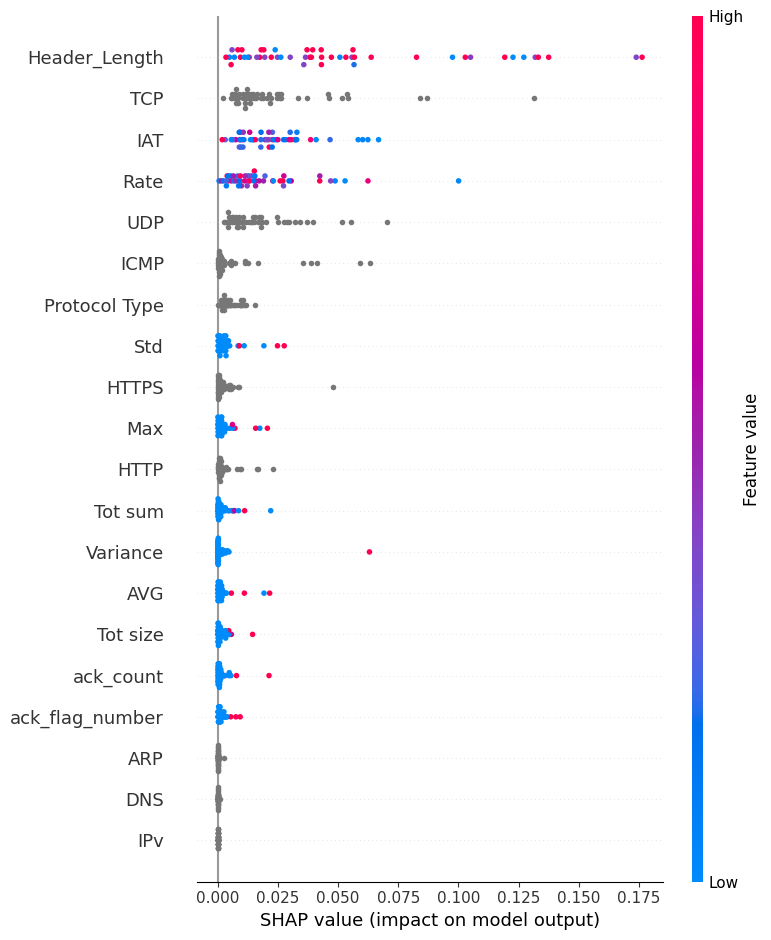

Valid SHAP Features from LSTM: ['Header_Length', 'Protocol Type', 'Rate', 'ack_flag_number', 'ack_count', 'HTTP', 'HTTPS', 'TCP', 'UDP', 'ICMP', 'Tot sum', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Variance']


In [ ]:
# Call function and store valid features
valid_lstm_features, shap_values_lstm = get_valid_shap_features_cnn(lstm_model, X_test)

print("Valid SHAP Features from LSTM:", valid_cnn_features)


=== Feature Importance from SHAP Analysis (LSTM) ===
Header_Length: 0.0523
psh_flag_number: 0.0240
HTTPS: 0.0228
Time_To_Live: 0.0191
ack_flag_number: 0.0169
cwr_flag_number: 0.0073
Protocol Type: 0.0047
rst_count: 0.0038
rst_flag_number: 0.0030
syn_count: 0.0029
syn_flag_number: 0.0027
ack_count: 0.0023
DNS: 0.0021
fin_count: 0.0021
HTTP: 0.0017
fin_flag_number: 0.0016
Rate: 0.0015
ece_flag_number: 0.0002


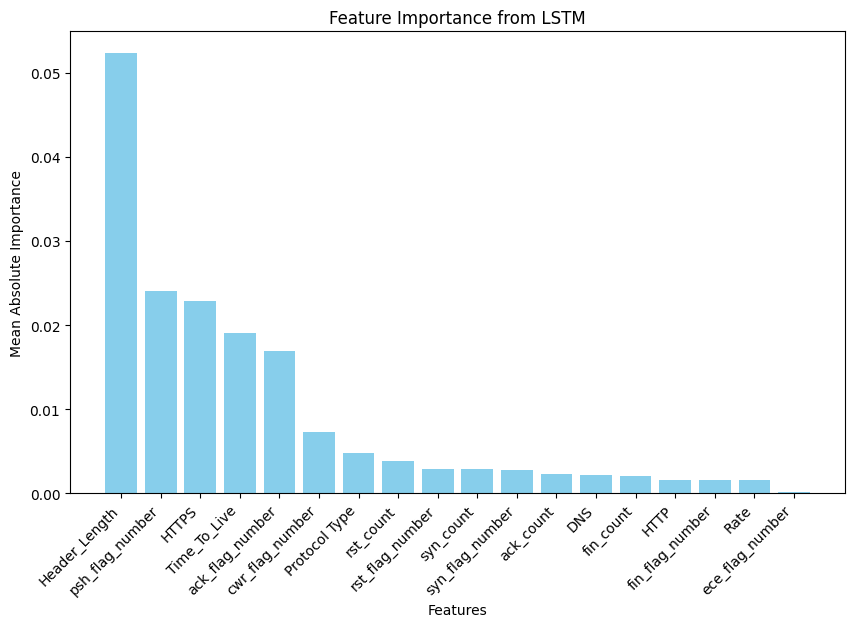

In [ ]:
# Convert feature names to indices
feature_indices = [X_test.columns.get_loc(feature) for feature in valid_lstm_features]

# Compute mean absolute SHAP values for selected features
feature_importance_lstm = np.mean(np.abs(shap_values_lstm[:, feature_indices]), axis=0)

# Convert 2D array into 1D
feature_importance_lstm = feature_importance_lstm.flatten()

# Sort feature importance in descending order
sorted_indices = np.argsort(feature_importance_lstm)[::-1]
sorted_feature_names = [X_test.columns[i] for i in sorted_indices]  # Get feature names

# Print Feature Importance
print("\n=== Feature Importance from SHAP Analysis (LSTM) ===")
for name, importance in zip(sorted_feature_names, feature_importance_lstm[sorted_indices]):
    print(f"{name}: {importance:.4f}")

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, feature_importance_lstm[sorted_indices], color='skyblue')
plt.xlabel('Features')
plt.ylabel('Mean Absolute Importance')
plt.title('Feature Importance from LSTM')
plt.xticks(rotation=45, ha='right')  # Rotate feature names for better visibility
plt.show()

## Hybrid CNN-LSTM Model


In [ ]:
# Merge valid features from all models
final_hybrid_features = list( set(valid_cnn_features) | set(valid_lstm_features))

print("Final Selected Features for Hybrid Model:", final_hybrid_features)

# Filter dataset to only keep selected features
hybrid_data = merged_df[final_hybrid_features]

Final Selected Features for Hybrid Model: ['ack_flag_number', 'AVG', 'Tot size', 'Rate', 'HTTPS', 'IAT', 'Protocol Type', 'UDP', 'TCP', 'Variance', 'ICMP', 'HTTP', 'Header_Length', 'ack_count', 'ARP', 'Tot sum', 'Max', 'Std']


In [ ]:
final_hybrid_features = ['ack_flag_number', 'AVG', 'Tot size', 'Rate', 'HTTPS', 'IAT', 'Protocol Type', 'UDP', 'TCP', 'Variance', 'ICMP', 'HTTP', 'Header_Length', 'ack_count', 'ARP', 'Tot sum', 'Max', 'Std']
hybrid_data = merged_df[final_hybrid_features]

In [ ]:
def build_hybrid_cnn_lstm_model(input_shape, num_classes):
    """
    Builds a hybrid CNN-LSTM model using the filtered dataset.

    Args:
        input_shape (tuple): Shape of the input data (num_features,).
        num_classes (int): Number of output classes.

    Returns:
        tf.keras.Model: The hybrid CNN-LSTM model.
    """
    # Input layer for the filtered dataset (hybrid_data)
    input_layer = Input(shape=input_shape)

    # CNN part: Conv1D + MaxPooling1D
    cnn_layer = Conv1D(64, 3, activation='relu')(input_layer)
    cnn_layer = MaxPooling1D(2)(cnn_layer)
    cnn_layer = Flatten()(cnn_layer)  # Flatten for concatenation later

    # LSTM part
    lstm_layer = LSTM(64)(input_layer)  # LSTM layer

    # Concatenate CNN and LSTM outputs
    merged = concatenate([cnn_layer, lstm_layer])

    # Dense layers for further processing
    dense_layer = Dense(64, activation='relu')(merged)
    output_layer = Dense(num_classes, activation='softmax')(dense_layer)

    # Create the hybrid model
    hybrid_model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the hybrid model
    hybrid_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return hybrid_model


In [ ]:
def evaluate_hybrid_model(model, X_test, y_test, training_time):
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Convert y_test if it's one-hot encoded
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_test_classes = np.argmax(y_test, axis=1)
    else:
        y_test_classes = y_test  # Already in label format

    # Calculate metrics
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

    # Store results in DataFrame
    results_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'Training Time'],
        'Value': [accuracy, precision, recall, f1, training_time]
    })

    print(results_df)

    return results_df

In [ ]:
# Ensure hybrid_data is split the same way as your original training data
X_train, X_test, y_train, y_test = train_test_split(hybrid_data, y, test_size=0.2, random_state=42)

# Convert the labels to one-hot encoding (if necessary)
y_train = to_categorical(y_train, num_classes=8)  # Replace 8 with your actual number of classes
y_test = to_categorical(y_test, num_classes=8)

# Reshape the data for CNN input (adding extra dimension for CNN)
X_train = np.expand_dims(X_train.values, axis=-1)  # Adding an extra dimension for CNN (samples, features, 1)
X_test = np.expand_dims(X_test.values, axis=-1)  # Same reshaping for test data

# Input shape for the hybrid model
input_shape = (X_train.shape[1], 1)  # Shape based on the number of features (with an extra dimension for CNN)

# Build the hybrid CNN-LSTM model
num_classes = 8  # Set this to your actual number of classes
hybrid_model = build_hybrid_cnn_lstm_model(input_shape, num_classes)

# Train the model
start_time = time.time()
hybrid_model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test))

# Calculate training time
hybrid_cnn_lstm_training_time = time.time() - start_time
print(f"Hybrid CNN-LSTM Model Training Time: {hybrid_cnn_lstm_training_time:.2f} seconds")

# Optionally, evaluate the model on the test set
test_loss, test_accuracy = hybrid_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/3
17808/17808 ━━━━━━━━━━━━━━━━━━━━ 229s 13ms/step - accuracy: 0.7864 - loss: 0.5066 - val_accuracy: 0.7991 - val_loss: 0.4602
Epoch 2/3
17808/17808 ━━━━━━━━━━━━━━━━━━━━ 260s 13ms/step - accuracy: 0.7988 - loss: 0.4574 - val_accuracy: 0.8012 - val_loss: 0.4518
Epoch 3/3
17808/17808 ━━━━━━━━━━━━━━━━━━━━ 260s 12ms/step - accuracy: 0.7996 - loss: 0.4539 - val_accuracy: 0.8005 - val_loss: 0.4491
Hybrid CNN-LSTM Model Training Time: 749.19 seconds
4452/4452 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.8003 - loss: 0.4501
Test Loss: 0.4491, Test Accuracy: 0.8005


In [ ]:
hybrid_model.save("/mnt/hybrid_model_cnn_lstm.h5")
hybrid_cnn_lstm = evaluate_hybrid_model(model=hybrid_model, X_test=X_test, y_test=y_test, training_time=hybrid_cnn_lstm_training_time)

4452/4452 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step
          Metric       Value
0       Accuracy    0.800512
1      Precision    0.766534
2         Recall    0.800512
3       F1-score    0.741459
4  Training Time  749.193997


In [ ]:
import logging, os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger("tensorflow").setLevel(logging.ERROR)

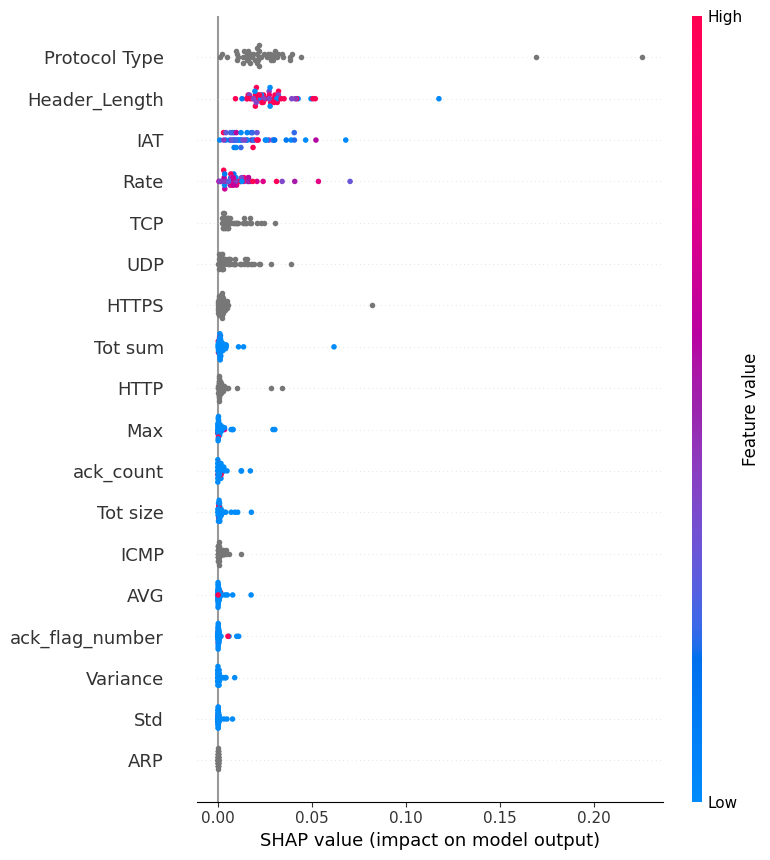

Valid SHAP Features from Hybrid CNN-LSTM: ['ack_flag_number', 'AVG', 'Tot size', 'Rate', 'HTTPS', 'IAT', 'Protocol Type', 'UDP', 'TCP', 'Variance', 'ICMP', 'HTTP', 'Header_Length', 'ack_count', 'Tot sum', 'Max', 'Std']


In [ ]:
def get_valid_shap_features_hybrid(model, X_test, hybrid_data, threshold=0.0001):
    import shap
    import numpy as np
    import pandas as pd
    import tensorflow as tf

    tf.config.run_functions_eagerly(True)

    if isinstance(X_test, pd.DataFrame):
        X_test_values = X_test.values
    else:
        X_test_values = X_test

    X_test_cnn = X_test_values.reshape(-1, X_test_values.shape[1], 1)
    X_test_cnn_sample = X_test_cnn[:50]

    explainer = shap.GradientExplainer(model, X_test_cnn_sample)
    shap_values = explainer.shap_values(X_test_cnn_sample)

    if isinstance(shap_values, list):
        shap_values = np.array(shap_values)

    shap_values = np.squeeze(shap_values, axis=2)

    if shap_values.ndim == 3:
        shap_values = np.mean(np.abs(shap_values), axis=-1)

    if shap_values.ndim != 2:
        raise ValueError(f"Expected SHAP values to be 2D but got shape {shap_values.shape}")

    mean_shap_values = np.mean(np.abs(shap_values), axis=0)

    if mean_shap_values.ndim != 1:
        raise ValueError(f"Expected mean SHAP values to be 1D but got shape {mean_shap_values.shape}")

    feature_importance = pd.DataFrame({
        "Feature": hybrid_data.columns,
        "SHAP_Value": mean_shap_values
    })

    valid_features = feature_importance[feature_importance["SHAP_Value"] > threshold]["Feature"].tolist()

    if X_test_cnn_sample.shape[0] != shap_values.shape[0]:
        raise ValueError(f"Mismatch in shape: {X_test_cnn_sample.shape[0]} vs {shap_values.shape[0]}")

    X_test_sample = hybrid_data.iloc[:50]
    shap.summary_plot(shap_values, X_test_sample, feature_names=hybrid_data.columns)

    return valid_features, shap_values


# Call function and store valid features
valid_hybrid_features, shap_values_hybird = get_valid_shap_features_hybrid(hybrid_model, X_test, hybrid_data)

print("Valid SHAP Features from Hybrid CNN-LSTM:", valid_hybrid_features)


=== Feature Importance from SHAP Analysis (CNN-LSTM) ===
Protocol Type: 0.0288
Header_Length: 0.0288
IAT: 0.0185
Rate: 0.0130
TCP: 0.0083
UDP: 0.0079
HTTPS: 0.0037
ARP: 0.0033
HTTP: 0.0029
Tot sum: 0.0024
ack_count: 0.0019
Tot size: 0.0018
ICMP: 0.0014
AVG: 0.0012
ack_flag_number: 0.0010
Variance: 0.0010
Max: 0.0007


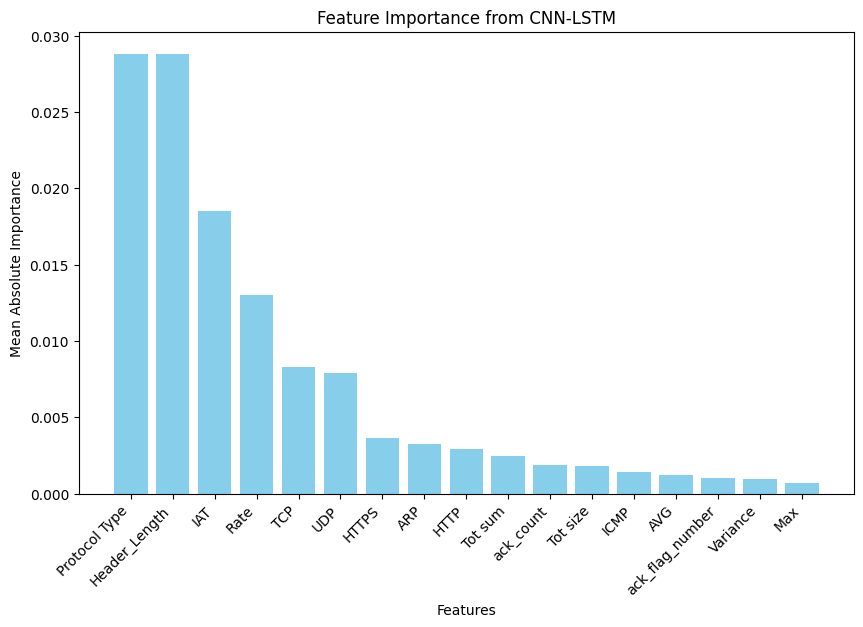

In [ ]:
# Convert feature names to indices
feature_indices = [hybrid_data.columns.get_loc(feature) for feature in valid_hybrid_features]

# Compute mean absolute SHAP values for selected features
feature_importance_hybrid= np.mean(np.abs(shap_values_hybird[:, feature_indices]), axis=0)

# Convert 2D array into 1D
feature_importance_hybrid = feature_importance_hybrid.flatten()

# Sort feature importance in descending order
sorted_indices = np.argsort(feature_importance_hybrid)[::-1]
sorted_feature_names = [hybrid_data.columns[i] for i in sorted_indices]  # Get feature names

# Print Feature Importance
print("\n=== Feature Importance from SHAP Analysis (CNN-LSTM) ===")
for name, importance in zip(sorted_feature_names, feature_importance_hybrid[sorted_indices]):
    print(f"{name}: {importance:.4f}")

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, feature_importance_hybrid[sorted_indices], color='skyblue')
plt.xlabel('Features')
plt.ylabel('Mean Absolute Importance')
plt.title('Feature Importance from CNN-LSTM')
plt.xticks(rotation=45, ha='right')  # Rotate feature names for better visibility
plt.show()

## Hybrid XGB-CNN Model

In [ ]:
# Merge valid features from all models
final_hybrid_features_xgb = list( set(valid_cnn_features) | set(valid_xgb_features))

print("Final Selected Features for Hybrid Model:", final_hybrid_features_xgb)



NameError: name 'valid_cnn_features' is not defined

In [ ]:
final_hybrid_features_xgb = ['ack_flag_number', 'IAT', 'HTTPS', 'Rate', 'IGMP', 'Tot sum', 'Protocol Type', 'syn_count', 'DHCP', 'IPv', 'UDP', 'DNS', 'Std', 'Header_Length', 'ICMP', 'Tot size', 'ARP', 'ack_count', 'AVG', 'syn_flag_number', 'SSH', 'TCP', 'HTTP', 'Variance', 'Max']
# Filter dataset to only keep selected features
hybrid_data_xgb = merged_df[final_hybrid_features_xgb]

In [ ]:
def build_cnn_model(input_shape, num_classes):
    """
    Builds a CNN model.

    Args:
        input_shape (tuple): Shape of the input data.
        num_classes (int): Number of output classes.

    Returns:
        tf.keras.Model: The CNN model.
    """
    input_layer = Input(shape=input_shape)

    # CNN Layers
    x = Conv1D(filters=32, kernel_size=3, activation='relu')(input_layer)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    cnn_model = Model(inputs=input_layer, outputs=output_layer)
    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return cnn_model

In [ ]:
def build_xgb_model(X_train, y_train, num_classes):
    """
    Builds and trains an XGBoost model.

    Args:
        X_train (array-like): Training data features.
        y_train (array-like): Training data labels.
        num_classes (int): Number of output classes.

    Returns:
        xgboost.XGBClassifier: The trained XGBoost model.
    """
    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Define and train the XGBoost model
    xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=num_classes, eval_metric='mlogloss')
    xgb_model.fit(X_train_scaled, y_train)

    return xgb_model, scaler

In [ ]:
from tensorflow.keras.layers import Lambda

def build_hybrid_cnn_xgb_model_v2(cnn_model, xgb_features_shape, num_classes):
    """
    Builds a hybrid CNN-XGBoost model using precomputed XGBoost features.

    Args:
        cnn_model (tf.keras.Model): CNN submodel.
        xgb_features_shape (int): Number of features output by XGBoost (num_classes typically).
        num_classes (int): Number of output classes.

    Returns:
        tf.keras.Model: The hybrid model.
    """

    # CNN input path
    cnn_input = Input(shape=(25, 1), name="cnn_input")  # Use your actual shape here
    cnn_output = cnn_model(cnn_input)

    # XGBoost input path
    xgb_input = Input(shape=(xgb_features_shape,), name="xgb_input")

    # Combine CNN and XGBoost outputs
    merged = concatenate([cnn_output, xgb_input])
    dense_layer = Dense(64, activation='relu')(merged)
    output_layer = Dense(num_classes, activation='softmax')(dense_layer)

    # Define and compile model
    hybrid_model = Model(inputs=[cnn_input, xgb_input], outputs=output_layer)
    hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return hybrid_model

In [ ]:
# Assuming 'y' is the target variable (labels) and the rest are the features
X = hybrid_data_xgb
y = merged_df['Label_class']

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_cat = to_categorical(y_train_xgb, num_classes=8)

In [ ]:
# Assuming the input shape is (X_train.shape[1], 1)
cnn_model = build_cnn_model(input_shape=(X_train_xgb.shape[1], 1), num_classes=8)
cnn_model.fit(X_train_xgb, y_train_cat, epochs=3, batch_size=128, validation_split=0.2)

Epoch 1/3
36505/36505 ━━━━━━━━━━━━━━━━━━━━ 203s 6ms/step - accuracy: 0.7902 - loss: 0.4955 - val_accuracy: 0.8056 - val_loss: 0.4423
Epoch 2/3
36505/36505 ━━━━━━━━━━━━━━━━━━━━ 202s 6ms/step - accuracy: 0.8011 - loss: 0.4528 - val_accuracy: 0.8059 - val_loss: 0.4377
Epoch 3/3
36505/36505 ━━━━━━━━━━━━━━━━━━━━ 201s 5ms/step - accuracy: 0.8030 - loss: 0.4482 - val_accuracy: 0.8076 - val_loss: 0.4399


In [ ]:
xgb_model, scaler = build_xgb_model(X_train_xgb, y_train_xgb, num_classes=8)

In [ ]:
# Step 1: Precompute XGBoost features
X_xgb_np = np.array(X_train_xgb)  # Just to be sure
X_xgb_flat = X_xgb_np.reshape((X_xgb_np.shape[0], -1))
X_xgb_scaled = scaler.transform(X_xgb_flat)
xgb_features = xgb_model.predict_proba(X_xgb_scaled)

# Step 2: Build hybrid model
hybrid_model = build_hybrid_cnn_xgb_model_v2(cnn_model, xgb_features.shape[1], num_classes=8)

start_time = time.time()
# Step 3: Train hybrid model
hybrid_model.fit(
    [X_train_xgb, xgb_features],
    y_train_cat,
    epochs=3,
    batch_size=128,
    validation_split=0.2
)
hybrid_cnn_xgb_traing_time = time.time() - start_time
print(f"Training Time: {hybrid_cnn_xgb_traing_time:.4f} seconds")

Epoch 1/3
36505/36505 ━━━━━━━━━━━━━━━━━━━━ 216s 6ms/step - accuracy: 0.8121 - loss: 0.4406 - val_accuracy: 0.8170 - val_loss: 0.4103
Epoch 2/3
36505/36505 ━━━━━━━━━━━━━━━━━━━━ 213s 6ms/step - accuracy: 0.8177 - loss: 0.4103 - val_accuracy: 0.8177 - val_loss: 0.4093
Epoch 3/3
36505/36505 ━━━━━━━━━━━━━━━━━━━━ 211s 6ms/step - accuracy: 0.8176 - loss: 0.4095 - val_accuracy: 0.8178 - val_loss: 0.4096
Training Time: 642.0419 seconds


In [ ]:
print(f"Training Time: {hybrid_cnn_xgb_traing_time:.4f} seconds")

Training Time: 642.0419 seconds


In [ ]:
def evaluate_hybrid_model(model, X_test_cnn_raw, X_test_xgb_raw, y_test, scaler, xgb_model, training_time):
    """
    Evaluate a hybrid CNN-XGBoost model.

    Args:
        model: Trained hybrid Keras model.
        X_test_cnn_raw: Raw test input for the CNN branch (e.g., shape (num_samples, 25, 1)).
        X_test_xgb_raw: Raw test input for the XGBoost branch (e.g., DataFrame or ndarray).
        y_test: True labels (can be one-hot or label-encoded).
        scaler: Scaler used for XGBoost input (e.g., StandardScaler).
        xgb_model: Trained XGBoost model.
        training_time: Training time of the model (float).

    Returns:
        results_df: DataFrame containing evaluation metrics.
    """

    # Step 1: Flatten and scale XGBoost input
    if isinstance(X_test_xgb_raw, pd.DataFrame):
        X_test_xgb_flat = X_test_xgb_raw.values.reshape((X_test_xgb_raw.shape[0], -1))
    else:
        X_test_xgb_flat = X_test_xgb_raw.reshape((X_test_xgb_raw.shape[0], -1))

    X_test_xgb_scaled = scaler.transform(X_test_xgb_flat)
    xgb_features_test = xgb_model.predict_proba(X_test_xgb_scaled)

    # Step 2: Run predictions on the hybrid model
    y_pred = model.predict([X_test_cnn_raw, xgb_features_test])
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Step 3: Handle one-hot or label-encoded ground truth
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_test_classes = np.argmax(y_test, axis=1)
    else:
        y_test_classes = y_test

    # Step 4: Calculate metrics
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

    # Step 5: Store results
    results_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'Training Time'],
        'Value': [accuracy, precision, recall, f1, training_time]
    })

    print(results_df)
    return results_df

In [ ]:
hybrid_model.save("/mnt/hybrid_model_cnn_xgb.h5")
# Step 1: Precompute XGBoost features for test data
X_test_np = np.array(X_test_xgb)
X_test_flat = X_test_np.reshape((X_test_np.shape[0], -1))
X_test_scaled = scaler.transform(X_test_flat)
xgb_features_test = xgb_model.predict_proba(X_test_scaled)

# Step 2: One-hot encode y_test for metrics (if needed)
y_test_cat = to_categorical(y_test_xgb, num_classes=8)

# Step 3: Evaluate the hybrid model
hybrid_metrics_df = evaluate_hybrid_model(
    model=hybrid_model,
    X_test_cnn_raw=X_test_xgb,      # Same shape as training input to CNN
    X_test_xgb_raw=X_test_xgb,      # Raw input for XGB to process and scale
    y_test=y_test_cat,              # Can also use y_test_xgb if not one-hot
    scaler=scaler,
    xgb_model=xgb_model,
    training_time=hybrid_cnn_xgb_traing_time
)


45631/45631 ━━━━━━━━━━━━━━━━━━━━ 66s 1ms/step
          Metric       Value
0       Accuracy    0.817112
1      Precision    0.791455
2         Recall    0.817112
3       F1-score    0.784485
4  Training Time  642.041891


In [1]:
def explain_hybrid_model_with_shap(hybrid_model, cnn_model, xgb_model, scaler,
                                   X_test_cnn, X_test_xgb, feature_names, threshold=0.0001):
    """
    Explains the CNN and XGB paths of the hybrid model separately using SHAP.

    Args:
        hybrid_model (tf.keras.Model): The full hybrid model (not used directly for SHAP).
        cnn_model (tf.keras.Model): The trained CNN model.
        xgb_model (xgb.XGBClassifier): The trained XGBoost model.
        scaler (StandardScaler): Scaler used to scale XGB input features.
        X_test_cnn (np.array): CNN input (shape: [n_samples, timesteps, 1]).
        X_test_xgb (pd.DataFrame or np.array): XGB input features (before scaling).
        feature_names (list): List of feature names.
        threshold (float): SHAP value threshold to filter valid features.

    Returns:
        dict: Dictionary with SHAP values and valid features for both paths.
    """

    tf.config.run_functions_eagerly(True)

    results = {}

    # ================= CNN Path SHAP ====================
    print("Explaining CNN path...")
    sample_cnn = X_test_cnn[:50]
    explainer_cnn = shap.GradientExplainer(cnn_model, sample_cnn)
    shap_values_cnn = explainer_cnn.shap_values(sample_cnn)

    if isinstance(shap_values_cnn, list):
        shap_values_cnn = np.array(shap_values_cnn)

    # For CNN, SHAP values will be: (num_classes, samples, timesteps, channels)
    shap_values_cnn = np.array(shap_values_cnn)  # shape: (num_classes, n_samples, timesteps, 1)

    # Aggregate across classes, samples, and channel axis
    mean_cnn_shap = np.mean(np.abs(shap_values_cnn), axis=(0, 1, 3))  # shape: (timesteps,)

    # Generate generic feature names if needed
    cnn_feature_names = [f"cnn_feature_{i}" for i in range(mean_cnn_shap.shape[0])]

    valid_features_cnn = [cnn_feature_names[i] for i, val in enumerate(mean_cnn_shap) if val > threshold]

    results["cnn_shap_values"] = shap_values_cnn
    results["cnn_valid_features"] = valid_features_cnn

    # ================= XGB Path SHAP ====================
    print("Explaining XGBoost path...")

    # Scale XGB input if needed (assuming same scaler used during training)
    sample_xgb = scaler.transform(X_test_xgb[:50])  # shape: (50, num_features)

    explainer_xgb = shap.TreeExplainer(xgb_model)
    shap_values_xgb = explainer_xgb.shap_values(sample_xgb)

    # shap_values_xgb shape: (n_samples, n_features) or (num_classes, n_samples, n_features)
    if isinstance(shap_values_xgb, list):  # multi-class
        shap_values_xgb = np.array(shap_values_xgb)
        shap_values_xgb = np.mean(np.abs(shap_values_xgb), axis=0)  # mean over classes: (n_samples, n_features)

    mean_xgb_shap = np.mean(np.abs(shap_values_xgb), axis=0)  # shape: (n_features,)

    # Feature names for XGB
    xgb_feature_names = [f"xgb_feature_{i}" for i in range(mean_xgb_shap.shape[0])]

    valid_features_xgb = []
    for i in range(len(mean_xgb_shap)):
        val = mean_xgb_shap[i]
        if isinstance(val, (list, np.ndarray)):
            val = np.mean(val)
        if val > threshold:
            valid_features_xgb.append(xgb_feature_names[i])

    results["xgb_shap_values"] = shap_values_xgb
    results["xgb_valid_features"] = valid_features_xgb

    # ============== Visualization =================
    print("Visualizing SHAP summary plots...")
    plt.figure(figsize=(14, 6))

    # CNN Summary
    plt.subplot(1, 2, 1)
    cnn_shap_vals_for_plot = np.mean(np.abs(shap_values_cnn), axis=0)  # (samples, timesteps, 1)
    cnn_shap_vals_for_plot = cnn_shap_vals_for_plot.squeeze()  # (samples, timesteps)
    cnn_feature_names = [f"cnn_feature_{i}" for i in range(cnn_shap_vals_for_plot.shape[1])]
    cnn_features_df = pd.DataFrame(X_test_cnn[:50].squeeze(), columns=cnn_feature_names)
    shap.summary_plot(cnn_shap_vals_for_plot, cnn_features_df, show=False)
    plt.title("CNN Path SHAP Summary")

    # XGB Summary
    plt.subplot(1, 2, 2)
    xgb_feature_names = [f"xgb_feature_{i}" for i in range(sample_xgb.shape[1])]
    xgb_features_df = pd.DataFrame(sample_xgb, columns=xgb_feature_names)
    shap.summary_plot(shap_values_xgb, xgb_features_df, show=False)
    plt.title("XGBoost Path SHAP Summary")

    plt.tight_layout()
    plt.show()


    return results

In [2]:
# CNN input shape: (samples, timesteps, 1)
X_test_cnn_input = np.array(X_test_xgb).reshape((-1, X_test_xgb.shape[1], 1))



# Run SHAP explainer
shap_results = explain_hybrid_model_with_shap(
    hybrid_model=hybrid_model,
    cnn_model=cnn_model,
    xgb_model=xgb_model,
    scaler=scaler,
    X_test_cnn=X_test_cnn_input,
    X_test_xgb=X_test_xgb,
    feature_names=X_test_xgb.columns.tolist()
)

# Print valid features
print("CNN Valid Features:", shap_results["cnn_valid_features"])
print("XGB Valid Features:", shap_results["xgb_valid_features"])

NameError: name 'np' is not defined

In [ ]:
# Identifying and visualizing important features from SHAP analysis for LSTM
feature_importance_hybrid_xgb_cnn = np.mean(np.abs(shap_values_hybrid_xgb_cnn), axis=(0, 1))  # Average across samples & timesteps

# Convert 2D array into 1D
feature_importance_hybrid_xgb_cnn = feature_importance_hybrid_xgb_cnn.flatten()

# Sort feature importance in descending order
sorted_indices = np.argsort(feature_importance_hybrid_xgb_cnn)[::-1]
sorted_feature_names = [X_test.columns[i] for i in sorted_indices]  # Get feature names

# Print Feature Importance
print("\n=== Feature Importance from SHAP Analysis (Hybrid CNN-XGB) ===")
for name, importance in zip(sorted_feature_names, feature_importance_hybrid_xgb_cnn[sorted_indices]):
    print(f"{name}: {importance:.4f}")

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, feature_importance_hybrid[sorted_indices], color='skyblue')
plt.xlabel('Features')
plt.ylabel('Mean Absolute Importance')
plt.title('Feature Importance from CNN-XGB')
plt.xticks(rotation=45, ha='right')  # Rotate feature names for better visibility
plt.show()

In [ ]:
metric_df_xgb

In [ ]:
cnn_metrics

In [ ]:
LSTM_Metrics

In [ ]:
hybrid_cnn_lstm

In [ ]:
hybrid_cnn_xgb_metric

In [ ]:
df_xgb = metric_df_xgb.T.reset_index()
df_xgb.columns = ["Metric", "XGBoost"]

df_cnn = pd.DataFrame(cnn_metrics, columns=["Metric", "Value"])
df_cnn.columns = ["Metric", "CNN"]

df_lstm = pd.DataFrame(LSTM_Metrics, columns=["Metric", "Value"])
df_lstm.columns = ["Metric", "LSTM"]

hybrid_cnn_lstm_df = pd.DataFrame(hybrid_cnn_lstm, columns=["Metric", "Value"])
hybrid_cnn_lstm_df.columns = ["Metric", "Hybrid CNN-LSTM"]

hybrid_cnn_xgb_metric_df = pd.DataFrame(hybrid_cnn_xgb_metric, columns=["Metric", "Value"])
hybrid_cnn_xgb_metric_df.columns = ["Metric", "Hybrid CNN-XGB"]

for df in [df_xgb, df_cnn, df_lstm, hybrid_cnn_lstm_df, hybrid_cnn_xgb_metric_df]:
    df["Metric"] = df["Metric"].str.replace(r"[_-]", " ", regex=True).str.strip().str.lower()

merged_df = (
    df_xgb
    .merge(df_cnn, on="Metric", how="outer")
    .merge(df_lstm, on="Metric", how="outer")
    .merge(hybrid_cnn_lstm_df, on="Metric", how="outer")
    .merge(hybrid_cnn_xgb_metric_df, on="Metric", how="outer")
)

merged_df["Metric"] = merged_df["Metric"].str.title()
merged_df = merged_df.groupby("Metric", as_index=False).first()

# Display the cleaned DataFrame
merged_df